# 0.0. IMPORTS

In [1]:
import pandas as pd
import inflection
import math
from IPython.display import Image
from datetime import datetime
from datetime import timedelta

## 0.1. Helper Functions

## 0.2. Loading Data

In [2]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [3]:
df_raw.sample(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
356597,645,1,2014-08-25,7764,1035,1,0,0,1,a,a,90.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
421227,543,4,2014-06-19,0,0,0,1,a,0,c,a,1080.0,12.0,2012.0,0,NaN,NaN,NaN
459891,182,4,2014-05-15,4172,362,1,0,0,0,d,c,1390.0,NaN,NaN,1,9.0,2011.0,"Mar,Jun,Sept,Dec"
225950,721,6,2015-01-10,7817,726,1,0,0,0,a,c,3590.0,9.0,2012.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
231991,72,7,2015-01-04,0,0,0,0,0,0,a,a,2200.0,12.0,2009.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


# 1.0. STEP 01 - DATA DESCRIPTION

In [4]:
# copy original data
df1 = df_raw.copy()

## 1.1. Rename Columns

In [5]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']

# Apply snakecase to columns names
snakecase = lambda x: inflection.underscore( x )
cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new

## 1.2. Data Dimensions

In [6]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


## 1.3. Data Types

In [7]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [8]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [9]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
436860,566,4,2014-06-05,5315,564,1,1,0,0,a,a,3620.0,NaN,NaN,1,40.0,2013.0,"Jan,Apr,Jul,Oct"


In [10]:
df1['competition_distance'].max()

75860.0

In [11]:
#competition_distance
# market analysis assumption: position without values means a far competition distance, higher than the
# maximum value from the raw data.
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month
# Assumption: for NA values apply the value from "date" column, because the competition does exist and it can affect
# over time the sales performance.
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year
# Same assumption as competition_open_since_month
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week
# Assumptions: 1. NA values mean the store did not take place in promo2. 2. apply the value from "date" column.
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval
# Dictionary for Months
month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

# Fill NA values with zero.
df1['promo_interval'].fillna(0, inplace=True)

# Add new column with month information
df1['month_map'] = df1['date'].dt.month.map(month_map)

# New column that shows if at that date the store was in promo2.
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [12]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

# 2.0. STEP 02 - FEATURE ENGINEERING

In [13]:
df2 = df1.copy()

## 2.1. Mind Map Hypothesis

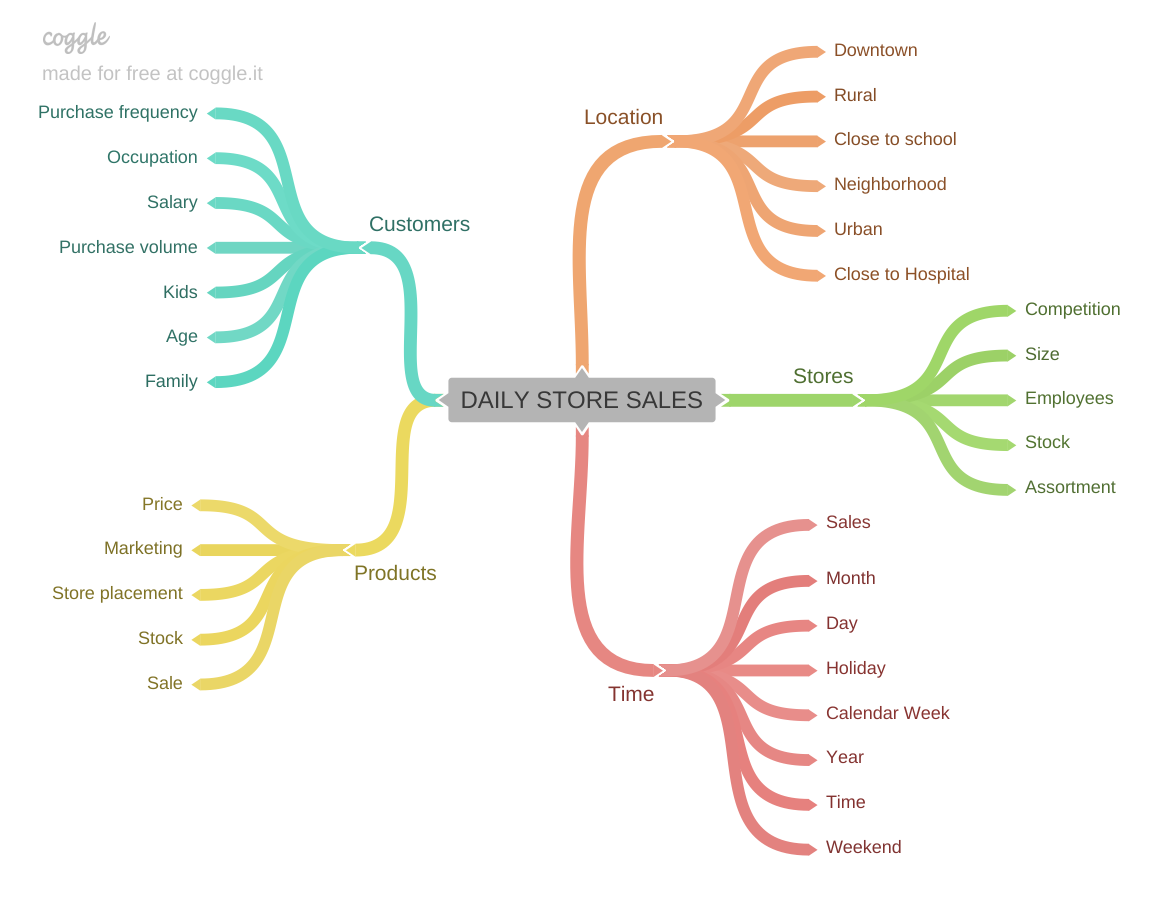

In [14]:
Image('img/Mindmaphypothesis.png')

## 2.2. Hypothesis Creation

### 2.2.1. Store Hypothesis

**1.** Stores with bigger staff (employees) should sell more.

**2.** Stores with bigger Stock should sell more.

**3.** Stores with bigger size should sell more.

**4.** Stores with bigger Assortment should sell more.

**5.** Stores with competition closer should sell less.

**6.** Stores with longer time competition should sell more.

### 2.2.2. Product Hypothesis

**1.** Stores that invest more on Marketing should sell more.

**2.** Stores that expose more the products (Store Placement) should sell more.

**3.** Stores with lower product prices should sell more.

**4.** Stores with more agressive Sale (bigger discount) should sell more.

**5.** Stores with longer Sale (promo) should sell more.

**6.** Stores with more Sale (promo) days should sell more.

**7.** Stores with more consecutive Sale (promo) should sell more.

### 2.2.3. Time Hypothesis

**1.** Stores open on Christmas time should sell more.

**2.** Stores should sell more throughout the years.

**3.** Stores should sell more on second semester.

**4.** Stores should sell more after the 10th months day.

**5.** Stores should sell less on weekend.

**6.** Stores should sell less while school vacation.

## 2.3. Final Hypothesis List (Based on the data available in the original dataset)

**1.** Stores with bigger Assortment should sell more.

**2.** Stores with competition closer should sell less.

**3.** Stores with longer time competition should sell more.

**4.** Stores with longer Sale (promo) should sell more.

**5.** Stores with more Sale (promo) days should sell more.

**6.** Stores with more consecutive Sale (promo) should sell more.

**7.** Stores open on Christmas time should sell more.

**8.** Stores should sell more throughout the years.

**9.** Stores should sell more on second semester.

**10.** Stores should sell more after the 10th months day.

**11.** Stores should sell less on weekend.

**12.** Stores should sell less while school vacation.

## 2.4. Feature Engineering

In [15]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [16]:
# convert float64 to int64
df2['competition_open_since_month'] = df2['competition_open_since_month'].astype('int64')
df2['competition_open_since_year'] = df2['competition_open_since_year'].astype('int64')
df2['promo2_since_week'] = df2['promo2_since_week'].astype('int64')
df2['promo2_since_year'] = df2['promo2_since_year'].astype('int64')

In [17]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
# Bring together competition_open_since_month and competition_open_since_year
# Assumption: day = 1, to consider the full month.
df2['competition_since'] = df2.apply( lambda x: datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1)

# Calculate the difference between date and competition_since. divide by 30 to keep the monthly granularity.
df2['competition_time_month'] = (( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

# promo since
# 1. Create a string 'year-week'
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
# 2. transform the string to date format ('year-month-day'). The day represents the first day of the week.
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.strptime( x + '-1', '%Y-%W-%w' ) - timedelta( days=7) )
# 3. create promo_time_week column with the difference between date and promo_since in weeks.
# df2['date'] - df2['promo_since'] divided by 7 beacuse we want it in weeks.
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [18]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. STEP 03 - VARIABLES FILTERING

In [19]:
df3 = df2.copy()

In [20]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1. Line Filtering

In [21]:
# closed stores (open = 0) means no sales. Therefore, it is not relevant for the sales forecast model. Open = 0 will be removed.
# sales = 0 will also be removed.
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Columns Selection

In [22]:
# Customers is a variable that is not available at the time of prediction, hence it is a business restriction.
# To use Customers variable, a new project is needed only for customers forecast in the next 6 weeks, and then use it as input in this sales forecast project.
# Therefore, the column customers must be removed.
# open only has values = 1(the lines with zeros were deleted above), hence the column can be removed.
# promo_interval generated new columns in the feature engineering step and is no longer needed.
# month_map is an auxiliary column and hence will be removed.
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

In [23]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')